In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## Steps to build a linear regression model
#### 1. Read and Understand the Data
#### 2. Prepare the data for modeling(train-test split, rescaling, feature selection etc.)
#### 3. Build and train the model
#### 4. Residual analysis
#### 5. Predicting and evaluating the model based on the Test set

### Step 1a : Read and Understand Data

In [3]:
### Get the data
bike_data = pd.read_csv("day.csv")

In [4]:
### Check the data have a look and feel of the data
bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
#### Check the columns in the data
bike_data.columns   

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [6]:
#### Get the basic information about the data
bike_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
#### Check if there are any missing values
bike_data.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

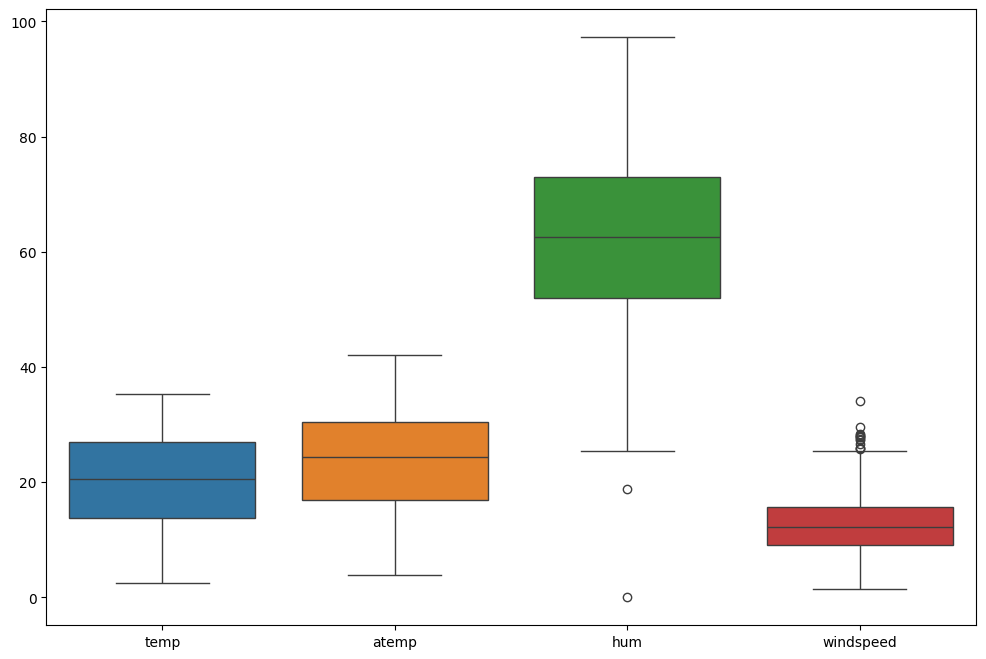

In [8]:
#### Check if there are any outliers in the data between temp, atemp, hum, windspeed, cnt
plt.figure(figsize=(12,8))
sns.boxplot(data=bike_data[['temp', 'atemp', 'hum', 'windspeed']])
plt.show()
#### There are no outliers in the data, hence no treatment is required

### Step 1b : Clean and Visualise data(EDA)

#### Remove Fields where are not necessary and can cause inconsistencies

In [9]:
bike_data = bike_data.drop(['instant','dteday','casual','registered'], axis=1)

#### Adjust Categorical Variable for Better Understanding

In [10]:
#### Analyze the Weather situation and its impact on the target variable
#### Convert them to readable form
bike_data['weathersit'].replace({1:'Clear',2:'Mist',3:'Rain',4:'Storm'},inplace=True)
#### Analyze the season and its impact on the target variable
##### convert to readable form
bike_data['season'].replace({1:'Spring',2:'Summer',3:'Fall', 4:'Winter'},inplace=True)
#### Analyze the month and its impact on the target variable
##### convert to readable form
bike_data['mnth'].replace({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},inplace=True)
#### Analyze the week day and its impact on the target variable
##### convert to readable form
bike_data['weekday'].replace({0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat'},inplace=True)
#### Analyze the year and its impact on the target variable
##### convert to readable form
bike_data['yr'].replace({0:'2018',1:'2019'},inplace=True)
#### Analyze the workingday and its impact on the target variable
##### convert to readable form
bike_data['workingday'].replace({0:'No',1:'Yes'},inplace=True)

<Axes: xlabel='workingday', ylabel='cnt'>

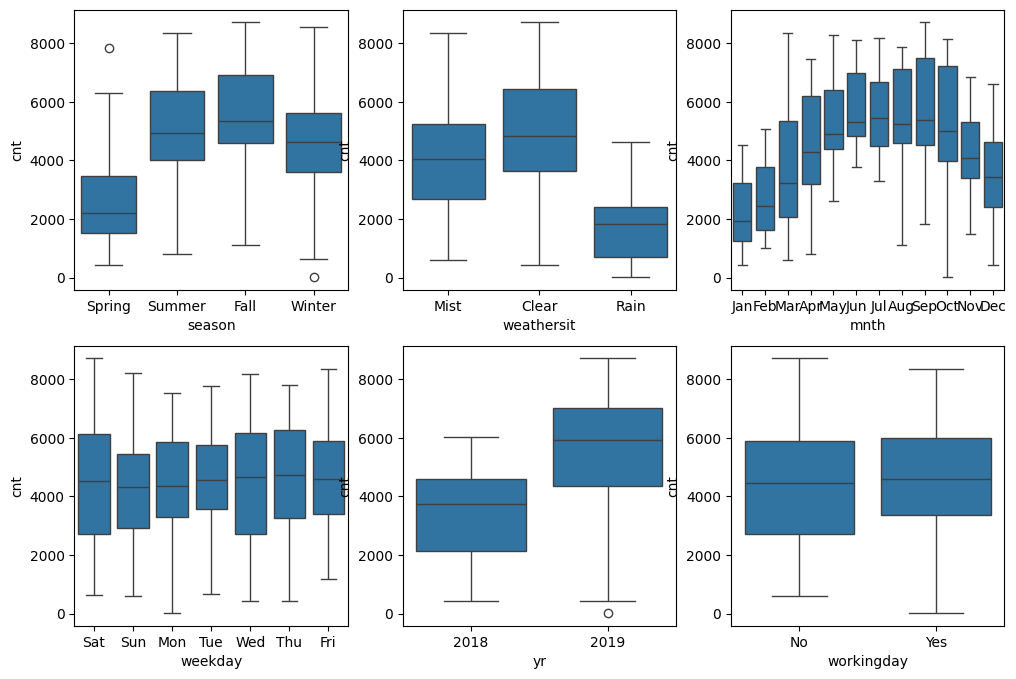

In [11]:
#### Visualise Categorical variables with Target Variable
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
sns.boxplot(x='season', y='cnt', data=bike_data)
plt.subplot(2,3,2)
sns.boxplot(x='weathersit', y='cnt', data=bike_data)
plt.subplot(2,3,3)
sns.boxplot(x='mnth', y='cnt', data=bike_data)
plt.subplot(2,3,4)
sns.boxplot(x='weekday', y='cnt', data=bike_data)
plt.subplot(2,3,5)
sns.boxplot(x='yr', y='cnt', data=bike_data)
plt.subplot(2,3,6)
sns.boxplot(x='workingday', y='cnt', data=bike_data)

#### Bike Rental count is high during Clear weather and low during light rain.
#### Bike Rental count is high during Summer and low during spring

<Figure size 1200x800 with 0 Axes>

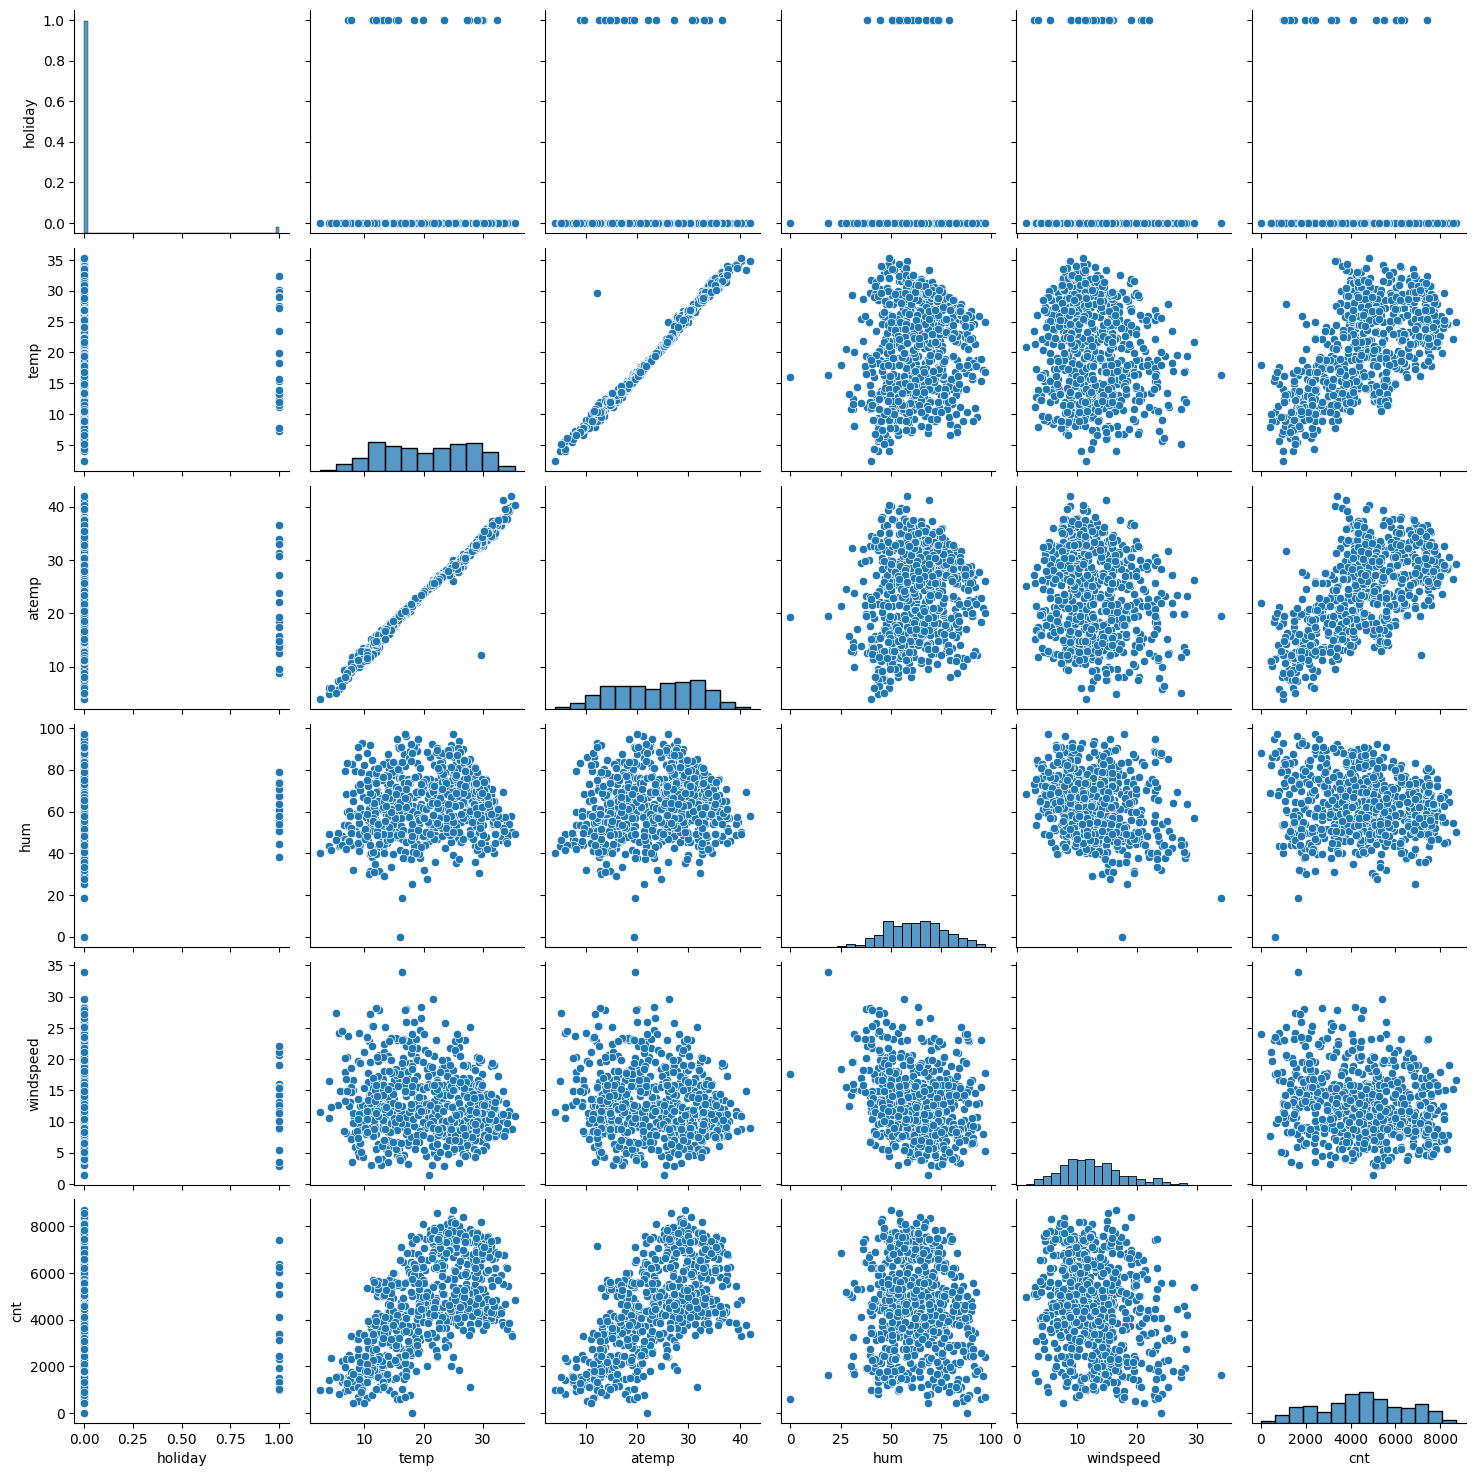

In [12]:
#### Understand relationship between Numeric variable and Target Variable
plt.figure(figsize=(12,8))
sns.pairplot(bike_data)
plt.show()
##### There is a strong positive correlation between temp and atemp and linear relationship between cnt and temp/atemp
##### Possiblity of multicollinearity, lets confirm using heatmap

#### Heatmap to understand correlation between variables

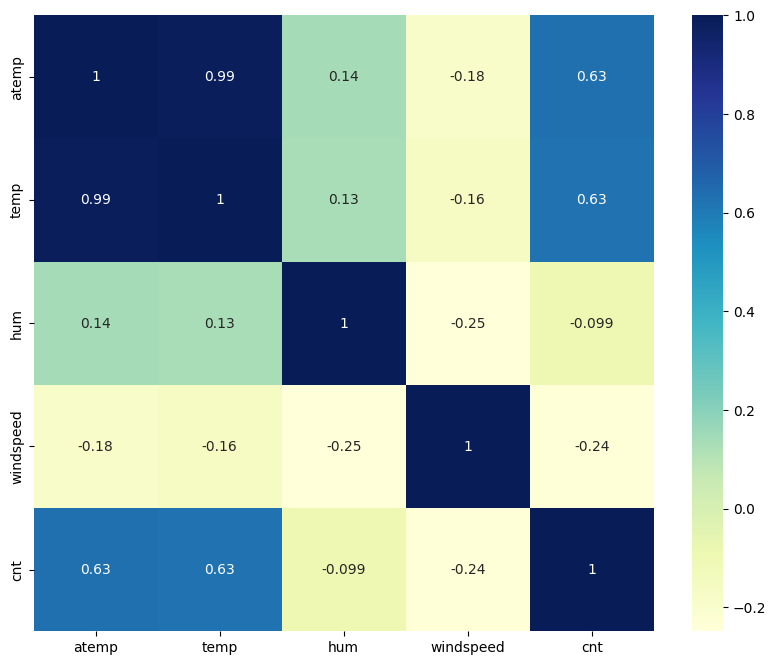

In [13]:
#### Heatmap to understand correlation between numerical variables
plt.figure(figsize=(10,8))
sns.heatmap(bike_data[['atemp', 'temp', 'hum', 'windspeed', 'cnt']].corr(), annot=True, cmap='YlGnBu')
plt.show()


In [14]:
#### There is a very high correlation between temp and atemp(0.99). We can drop one of them
# bike_data = bike_data.drop(['atemp'], axis=1)

## Step 2a: Identify and convert Categorical variables to numeric variable

In [15]:
varlist = ['season', 'weathersit', 'mnth', 'weekday', 'yr', 'workingday']
bike_data = pd.get_dummies(bike_data, columns=varlist, drop_first=True, dtype=int)
bike_data.head()

,holiday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,weathersit_Mist,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,yr_2019,workingday_Yes
0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


### Step 2b: Train test split

In [16]:
### Train Test Split
df_train, df_test = train_test_split(bike_data, train_size=0.7, random_state=100)

In [17]:
df_train.shape, df_test.shape

((510, 30), (220, 30))

### Step 2c : Rescaling

In [18]:
bike_data.head()

,holiday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,weathersit_Mist,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,yr_2019,workingday_Yes
0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [19]:
### MinMax(Normalization) : between 0 and 1
#### Step 1: Instantiate the , Requires scaler object to be imported from sklearn.preprocessing
scaler = MinMaxScaler()
#### Step 2 : Fit and transform the scaler on the data
num_vars = ['temp', 'hum', 'windspeed', 'cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()


,holiday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,weathersit_Mist,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,yr_2019,workingday_Yes
576,0,0.815169,33.1448,0.725633,0.264686,0.827658,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
426,0,0.442393,20.6746,0.640189,0.255342,0.465255,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
728,0,0.245101,11.5850,0.498067,0.663106,0.204096,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
482,0,0.395666,18.8752,0.504508,0.188475,0.482973,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
111,0,0.345824,16.0977,0.751824,0.380981,0.191095,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [20]:
### check if min and max values are between 0 and 1
df_train[num_vars].describe()

,temp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.650480,0.320883,0.513499
std,0.225858,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.538643,0.199179,0.356420
50%,0.542596,0.653714,0.296763,0.518638
75%,0.735215,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000


<Axes: >

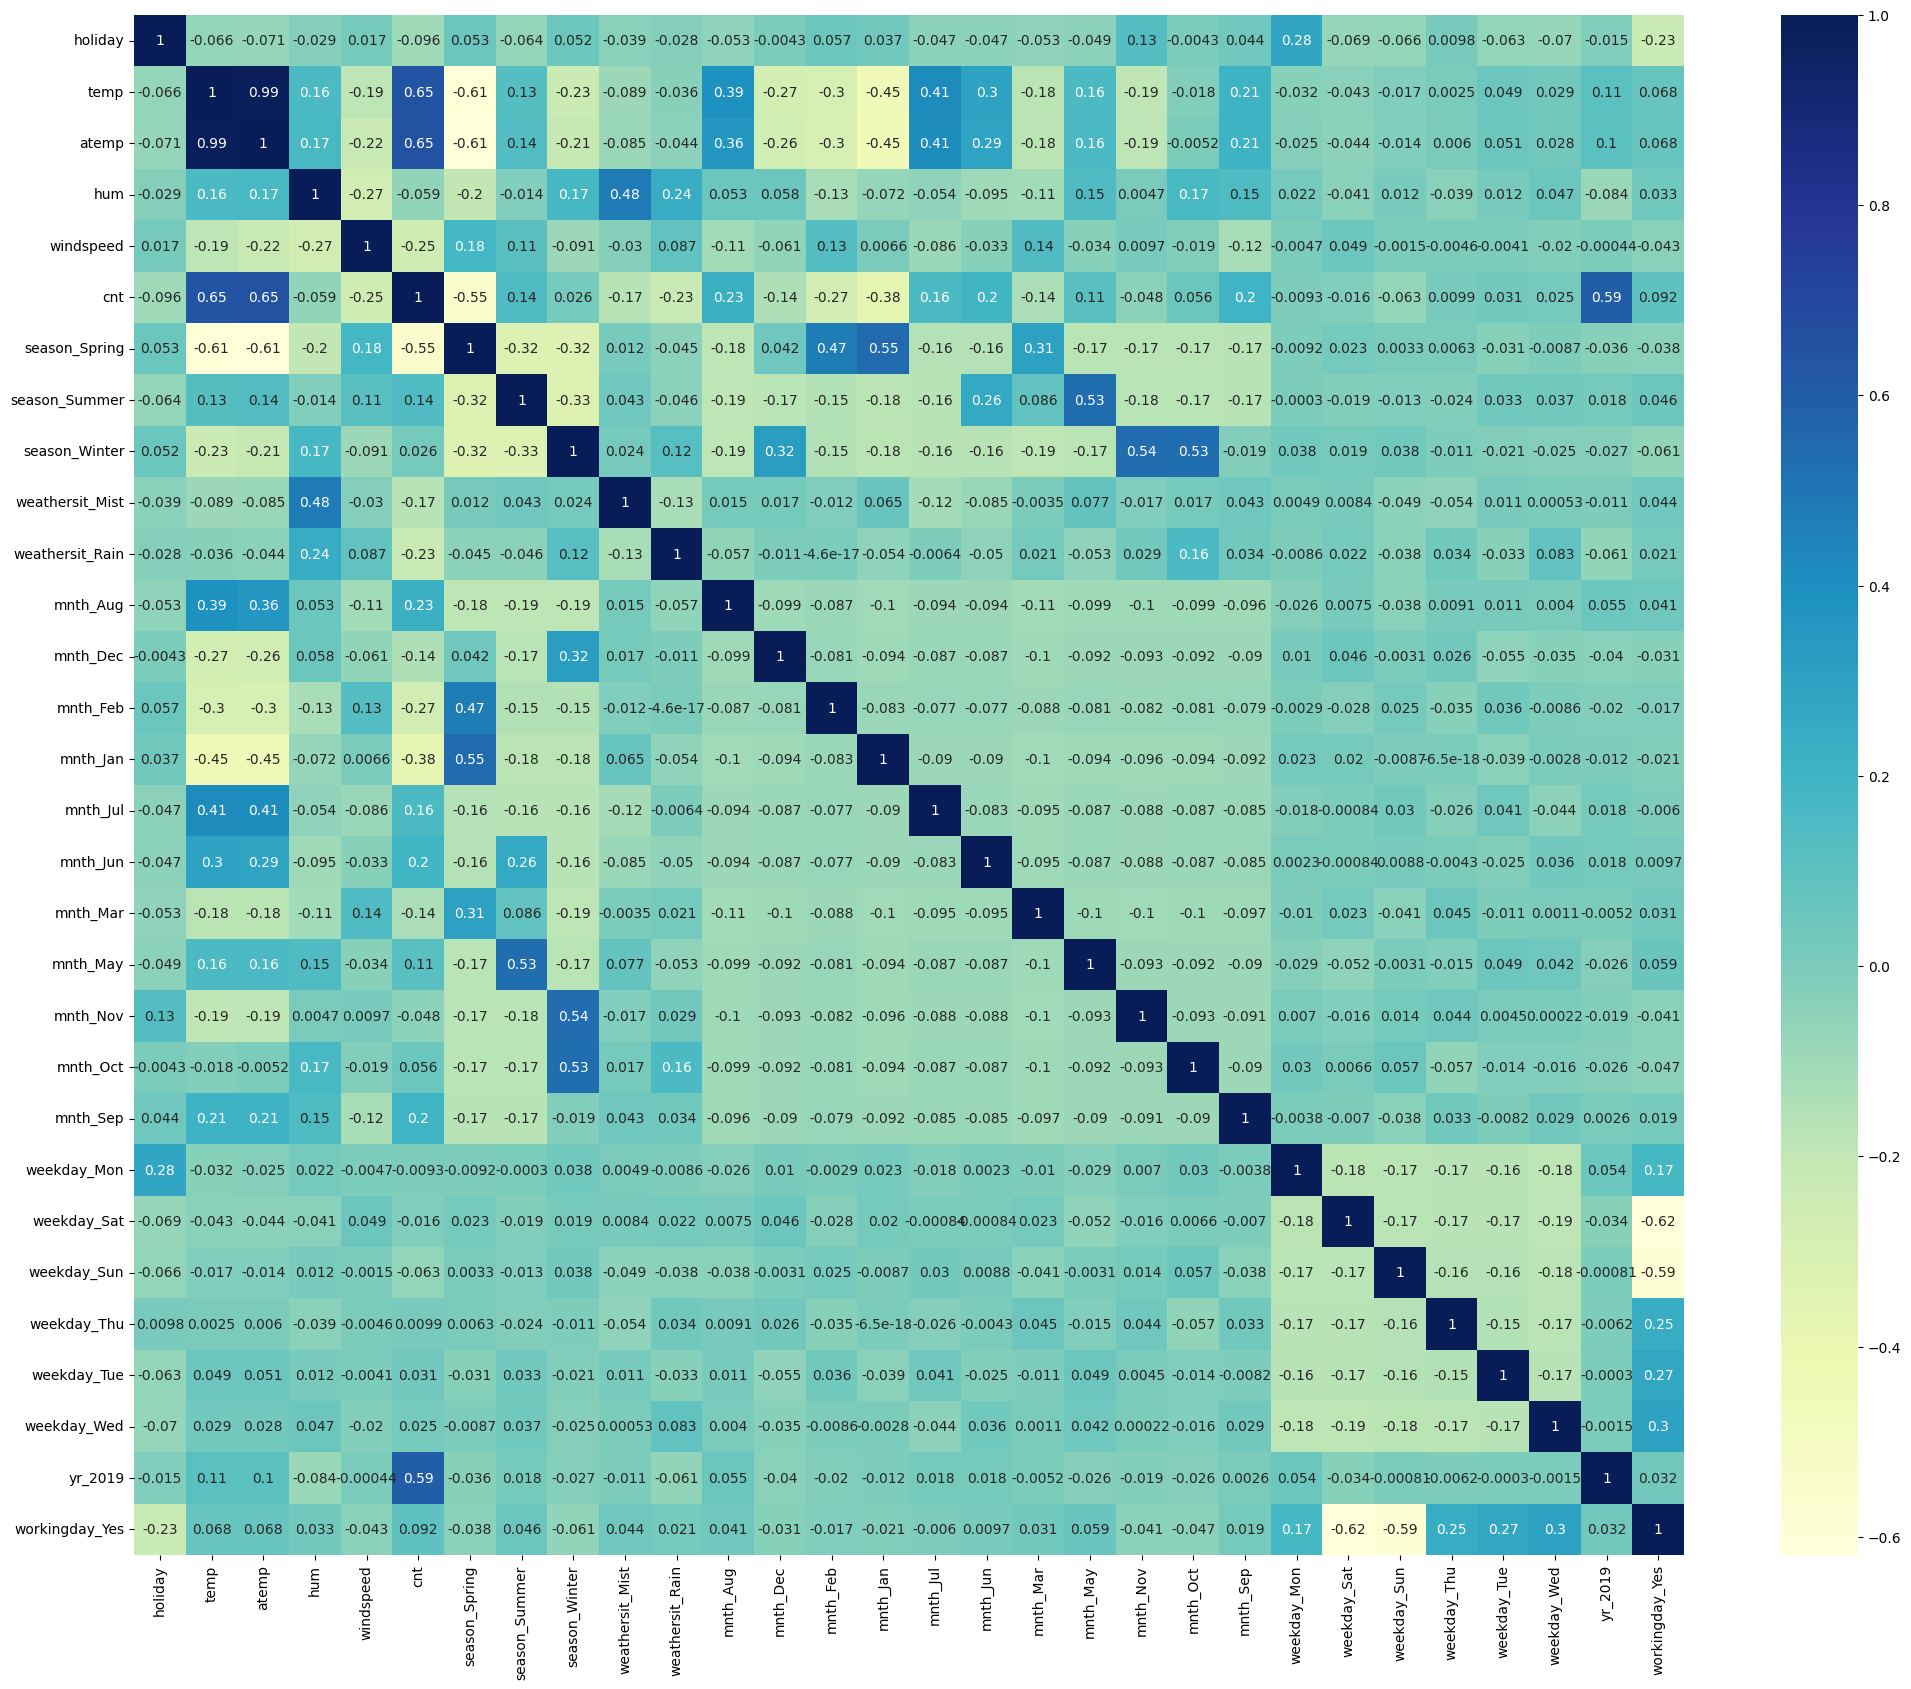

In [21]:
#### Heatmap to understand correlation between variables
plt.figure(figsize=(25,20))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")

### Step 3: Build and train a model


In [22]:
#### Pop out the target variable 'cnt' from the training data
x_train = df_train
y_train = x_train.pop('cnt')

In [23]:
#### Validate the train data shapes
x_train.shape, y_train.shape

((510, 29), (510,))

#### 29 Features available, RFE will be used, Hence let select 15


In [24]:
### Lr and Fit
lr = LinearRegression()
lr.fit(x_train, y_train)

### Recursive Feature Elimination
rfe = RFE(estimator=lr, n_features_to_select=15)
rfe = rfe.fit(x_train, y_train)

In [25]:
### Check selected features with rankings and column names
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('holiday', np.True_, np.int64(1)),
 ('temp', np.True_, np.int64(1)),
 ('atemp', np.False_, np.int64(15)),
 ('hum', np.True_, np.int64(1)),
 ('windspeed', np.True_, np.int64(1)),
 ('season_Spring', np.True_, np.int64(1)),
 ('season_Summer', np.True_, np.int64(1)),
 ('season_Winter', np.True_, np.int64(1)),
 ('weathersit_Mist', np.True_, np.int64(1)),
 ('weathersit_Rain', np.True_, np.int64(1)),
 ('mnth_Aug', np.False_, np.int64(6)),
 ('mnth_Dec', np.False_, np.int64(3)),
 ('mnth_Feb', np.False_, np.int64(4)),
 ('mnth_Jan', np.True_, np.int64(1)),
 ('mnth_Jul', np.True_, np.int64(1)),
 ('mnth_Jun', np.False_, np.int64(13)),
 ('mnth_Mar', np.False_, np.int64(14)),
 ('mnth_May', np.False_, np.int64(5)),
 ('mnth_Nov', np.False_, np.int64(2)),
 ('mnth_Oct', np.False_, np.int64(12)),
 ('mnth_Sep', np.True_, np.int64(1)),
 ('weekday_Mon', np.False_, np.int64(8)),
 ('weekday_Sat', np.True_, np.int64(1)),
 ('weekday_Sun', np.False_, np.int64(7)),
 ('weekday_Thu', np.False_, np.int64(10)),
 ('w

In [26]:
#### Get all the Column names where RFE support is True
col = x_train.columns[rfe.support_]
col

Index(['holiday', 'temp', 'hum', 'windspeed', 'season_Spring', 'season_Summer',
       'season_Winter', 'weathersit_Mist', 'weathersit_Rain', 'mnth_Jan',
       'mnth_Jul', 'mnth_Sep', 'weekday_Sat', 'yr_2019', 'workingday_Yes'],
      dtype='object')

In [27]:
### Lets look at the columns that has been not selected by RFE
x_train.columns[~rfe.support_]

Index(['atemp', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'weekday_Mon', 'weekday_Sun',
       'weekday_Thu', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

#### Build based on the above Selected 15 Columns.

### Model 1:

In [28]:
#### Model 1:
x_train_mdl1 = x_train[col]
x_train_mdl1 = sm.add_constant(x_train_mdl1)

lm_mdl1 = sm.OLS(y_train, x_train_mdl1)
lm_mdl1 = lm_mdl1.fit()
#### Model Summary
lm_mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          4.22e-191
Time:                        14:05:27   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2519      0.036      6.969      0.000       0.181       0.323
holiday            -0.0582      0.027     -2.164      0.031      -0.111      -0.005
temp                0.5096      0.034     14.837      0.000       0.442       0.577
hum                -0.1563      0.037     -4.188      0.000      -0.230      -0.083
windspeed          -0.1863      0.025     -7.310      0.000      -0.236      -0.136
season_Spring      -0.0509      0.021     -2.464      0.014      -0.091      -0.010
season_Summer       0.0508      0.015      3.423      0.001       0.022       0.080
season_Winter       0.0933      0.017      5.403      0.000       0.059       0.127
weathersit_Mist    -0.0563      0.010     -5.439      0.000      -0.077      -0.036
weathersit_Rain    -0.2475      0.026     -9.507      0.000      -0.299      -0.196
mnth_Jan           -0.0345      0.017     -1.989      0.047      -0.069      -0.000
mnth_Jul           -0.0529      0.018     -2.931      0.004      -0.088      -0.017
mnth_Sep            0.0814      0.016      4.945      0.000       0.049       0.114
weekday_Sat         0.0536      0.014      3.694      0.000       0.025       0.082
yr_2019             0.2305      0.008     28.795      0.000       0.215       0.246
workingday_Yes      0.0433      0.012      3.762      0.000       0.021       0.066
==============================================================================
Omnibus:                       66.260   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.826
Skew:                          -0.678   Prob(JB):                     1.97e-35
Kurtosis:                       5.383   Cond. No.                         22.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Manual Approach of elimination using VIF



In [29]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif

In [30]:
calculate_vif(x_train[col])

,Features,VIF
2,hum,29.37
1,temp,17.78
14,workingday_Yes,5.31
3,windspeed,4.73
4,season_Spring,4.53
6,season_Winter,3.46
5,season_Summer,2.85
7,weathersit_Mist,2.29
13,yr_2019,2.09
12,weekday_Sat,1.98


In [31]:
#### Humidity has high VIF, hence removing it from the model
col = col.drop('hum')
col

Index(['holiday', 'temp', 'windspeed', 'season_Spring', 'season_Summer',
       'season_Winter', 'weathersit_Mist', 'weathersit_Rain', 'mnth_Jan',
       'mnth_Jul', 'mnth_Sep', 'weekday_Sat', 'yr_2019', 'workingday_Yes'],
      dtype='object')

In [32]:
#### Build model again after removing hum column
#### Model 2:
x_train_mdl2 = x_train[col]
x_train_mdl2 = sm.add_constant(x_train_mdl2)

lm_mdl2 = sm.OLS(y_train, x_train_mdl2)
lm_mdl2 = lm_mdl2.fit()
#### Model Summary
lm_mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          1.60e-188
Time:                        14:05:27   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1737      0.031      5.520      0.000       0.112       0.235
holiday            -0.0558      0.027     -2.042      0.042      -0.109      -0.002
temp                0.4722      0.034     14.005      0.000       0.406       0.538
windspeed          -0.1563      0.025     -6.286      0.000      -0.205      -0.107
season_Spring      -0.0599      0.021     -2.867      0.004      -0.101      -0.019
season_Summer       0.0445      0.015      2.967      0.003       0.015       0.074
season_Winter       0.0784      0.017      4.562      0.000       0.045       0.112
weathersit_Mist    -0.0813      0.009     -9.437      0.000      -0.098      -0.064
weathersit_Rain    -0.2908      0.024    -11.977      0.000      -0.339      -0.243
mnth_Jan           -0.0392      0.018     -2.227      0.026      -0.074      -0.005
mnth_Jul           -0.0479      0.018     -2.614      0.009      -0.084      -0.012
mnth_Sep            0.0755      0.017      4.527      0.000       0.043       0.108
weekday_Sat         0.0583      0.015      3.968      0.000       0.029       0.087
yr_2019             0.2345      0.008     29.009      0.000       0.219       0.250
workingday_Yes      0.0464      0.012      3.966      0.000       0.023       0.069
==============================================================================
Omnibus:                       67.830   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.565
Skew:                          -0.692   Prob(JB):                     1.84e-36
Kurtosis:                       5.415   Cond. No.                         20.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
#### Calculate VIF again after Removal of "Humidity"
calculate_vif(x_train[col])

,Features,VIF
1,temp,7.07
13,workingday_Yes,5.24
2,windspeed,4.68
3,season_Spring,3.07
4,season_Summer,2.34
12,yr_2019,2.08
5,season_Winter,1.98
11,weekday_Sat,1.97
8,mnth_Jan,1.62
9,mnth_Jul,1.59


In [34]:
#### Removing Workingday as it have high VIF and not Temp has high corelation with cnt
col = col.drop('temp')

In [35]:
#### Build model again after removing workingday column
#### Model 3:
x_train_mdl3 = x_train[col]
x_train_mdl3 = sm.add_constant(x_train_mdl3)

lm_mdl3 = sm.OLS(y_train, x_train_mdl3)
lm_mdl3 = lm_mdl3.fit()
#### Model Summary
lm_mdl3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     135.7
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          6.44e-154
Time:                        14:05:27   Log-Likelihood:                 425.63
No. Observations:                 510   AIC:                            -823.3
Df Residuals:                     496   BIC:                            -764.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5444      0.020     27.118      0.000       0.505       0.584
holiday            -0.0567      0.032     -1.757      0.080      -0.120       0.007
windspeed          -0.1878      0.029     -6.426      0.000      -0.245      -0.130
season_Spring      -0.2602      0.018    -14.483      0.000      -0.296      -0.225
season_Summer      -0.0427      0.016     -2.651      0.008      -0.074      -0.011
season_Winter      -0.0762      0.016     -4.903      0.000      -0.107      -0.046
weathersit_Mist    -0.0882      0.010     -8.688      0.000      -0.108      -0.068
weathersit_Rain    -0.3034      0.029    -10.593      0.000      -0.360      -0.247
mnth_Jan           -0.1026      0.020     -5.112      0.000      -0.142      -0.063
mnth_Jul           -0.0095      0.021     -0.446      0.656      -0.052       0.032
mnth_Sep            0.0710      0.020      3.610      0.000       0.032       0.110
weekday_Sat         0.0562      0.017      3.243      0.001       0.022       0.090
yr_2019             0.2478      0.009     26.153      0.000       0.229       0.266
workingday_Yes      0.0478      0.014      3.466      0.001       0.021       0.075
==============================================================================
Omnibus:                       34.639   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.598
Skew:                          -0.421   Prob(JB):                     3.46e-15
Kurtosis:                       4.557   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
#### Lets check VIF again
calculate_vif(x_train[col])

,Features,VIF
1,windspeed,4.27
12,workingday_Yes,3.83
2,season_Spring,2.97
3,season_Summer,2.29
4,season_Winter,1.98
11,yr_2019,1.91
10,weekday_Sat,1.69
7,mnth_Jan,1.60
5,weathersit_Mist,1.57
8,mnth_Jul,1.30


In [37]:
####  P-value is high for holiday.
#### Hence removing weekday_Sat from the model
col = col.drop('holiday')

In [38]:
#### Build model again after removing mnth_jul
#### Model 4:
x_train_mdl4 = x_train[col]
x_train_mdl4 = sm.add_constant(x_train_mdl4)

lm_mdl4 = sm.OLS(y_train, x_train_mdl4)
lm_mdl4 = lm_mdl4.fit()
#### Model Summary
lm_mdl4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     146.1
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          2.41e-154
Time:                        14:05:27   Log-Likelihood:                 424.05
No. Observations:                 510   AIC:                            -822.1
Df Residuals:                     497   BIC:                            -767.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5364      0.020     27.369      0.000       0.498       0.575
windspeed          -0.1888      0.029     -6.448      0.000      -0.246      -0.131
season_Spring      -0.2611      0.018    -14.509      0.000      -0.296      -0.226
season_Summer      -0.0424      0.016     -2.627      0.009      -0.074      -0.011
season_Winter      -0.0771      0.016     -4.955      0.000      -0.108      -0.047
weathersit_Mist    -0.0876      0.010     -8.622      0.000      -0.108      -0.068
weathersit_Rain    -0.3022      0.029    -10.533      0.000      -0.359      -0.246
mnth_Jan           -0.1032      0.020     -5.132      0.000      -0.143      -0.064
mnth_Jul           -0.0084      0.021     -0.394      0.693      -0.051       0.034
mnth_Sep            0.0691      0.020      3.510      0.000       0.030       0.108
weekday_Sat         0.0648      0.017      3.880      0.000       0.032       0.098
yr_2019             0.2480      0.009     26.120      0.000       0.229       0.267
workingday_Yes      0.0562      0.013      4.335      0.000       0.031       0.082
==============================================================================
Omnibus:                       39.321   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.897
Skew:                          -0.456   Prob(JB):                     4.47e-18
Kurtosis:                       4.711   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
#### lets check VIF again
calculate_vif(x_train[col])

,Features,VIF
0,windspeed,4.21
11,workingday_Yes,3.54
1,season_Spring,2.92
2,season_Summer,2.26
3,season_Winter,1.91
10,yr_2019,1.91
9,weekday_Sat,1.62
6,mnth_Jan,1.60
4,weathersit_Mist,1.57
7,mnth_Jul,1.29


In [40]:
#### VIF is in Control now, But P-value of mnth_jul is slightly high.
#### Hence removing mnth_jul from the model
col = col.drop('mnth_Jul')

In [41]:
#### Build model again after removing holiday column
#### Model 5:
x_train_mdl5 = x_train[col]
x_train_mdl5 = sm.add_constant(x_train_mdl5)

lm_mdl5 = sm.OLS(y_train, x_train_mdl5)
lm_mdl5 = lm_mdl5.fit()
#### Model Summary
lm_mdl5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     159.7
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          2.01e-155
Time:                        14:05:27   Log-Likelihood:                 423.97
No. Observations:                 510   AIC:                            -823.9
Df Residuals:                     498   BIC:                            -773.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5332      0.018     30.023      0.000       0.498       0.568
windspeed          -0.1887      0.029     -6.450      0.000      -0.246      -0.131
season_Spring      -0.2581      0.016    -15.860      0.000      -0.290      -0.226
season_Summer      -0.0394      0.014     -2.768      0.006      -0.067      -0.011
season_Winter      -0.0743      0.014     -5.392      0.000      -0.101      -0.047
weathersit_Mist    -0.0874      0.010     -8.623      0.000      -0.107      -0.067
weathersit_Rain    -0.3023      0.029    -10.546      0.000      -0.359      -0.246
mnth_Jan           -0.1033      0.020     -5.138      0.000      -0.143      -0.064
mnth_Sep            0.0715      0.019      3.815      0.000       0.035       0.108
weekday_Sat         0.0648      0.017      3.887      0.000       0.032       0.098
yr_2019             0.2480      0.009     26.146      0.000       0.229       0.267
workingday_Yes      0.0564      0.013      4.353      0.000       0.031       0.082
==============================================================================
Omnibus:                       39.401   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.660
Skew:                          -0.459   Prob(JB):                     5.04e-18
Kurtosis:                       4.705   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
#### lets check VIF again
calculate_vif(x_train[col])

,Features,VIF
0,windspeed,4.04
10,workingday_Yes,3.29
1,season_Spring,2.65
2,season_Summer,2.00
9,yr_2019,1.88
3,season_Winter,1.73
6,mnth_Jan,1.60
4,weathersit_Mist,1.57
8,weekday_Sat,1.56
7,mnth_Sep,1.18


#### P Values are low(<0.05) and VIF is within control(<5), Hence we can move with Residual Analysis

### Step 3: Residual Analysis

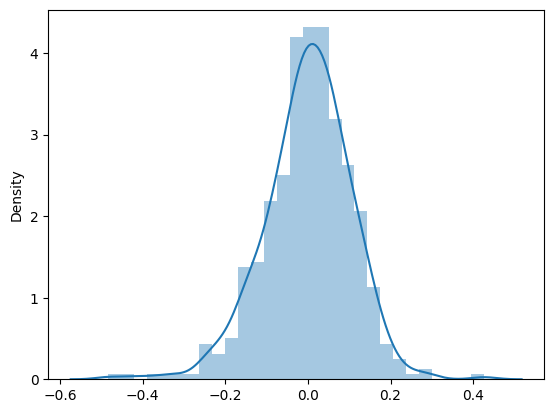

In [56]:
#### Calculate Resdiduals
x_train_final = x_train_mdl5
y_train_pred = lm_mdl5.predict(x_train_final)
residual = y_train - y_train_pred
sns.distplot(residual, label='Error terms', kde=True)
plt.show()
#### Residuals are normally distributed


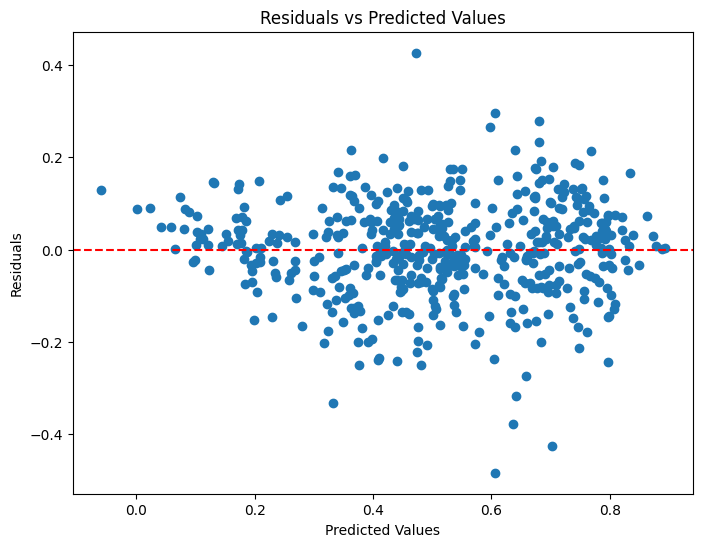

In [58]:
#### verifing correlation of residuals with predicted values
plt.figure(figsize=(8,6))
plt.scatter(y_train_pred, residual)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()
#### There is no correlation between residuals and predicted values and are randomly distributed around zero

### Step 4: Prediction and Evaluation of model based on test Set

In [46]:
#### Scaler Transform on the test data
num_vars = ['temp', 'hum', 'windspeed', 'cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,holiday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,weathersit_Mist,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,yr_2019,workingday_Yes
184,1,0.831783,33.27085,0.657364,0.084219,0.692706,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
535,0,0.901354,36.04875,0.610133,0.153728,0.712034,0,1,0,0,...,0,0,0,0,0,0,0,1,1,1
299,0,0.511964,22.85230,0.837699,0.334206,0.303382,0,0,1,1,...,1,0,0,0,0,1,0,0,0,1
221,0,0.881625,34.24915,0.437098,0.339570,0.547400,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
152,0,0.817246,32.19710,0.314298,0.537414,0.569029,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [47]:
#### Check the test data shape, check for Min and Max values
df_test.describe()

,holiday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,season_Winter,weathersit_Mist,...,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,yr_2019,workingday_Yes
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.036364,0.558718,24.250312,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,0.318182,...,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000,0.481818,0.700000
std,0.187620,0.233187,8.281075,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,0.466833,...,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684,0.500809,0.459303
min,0.000000,0.046591,4.941955,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.355429,17.090025,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.558172,24.700000,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.755981,31.124313,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,0.984424,41.318550,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
col

Index(['windspeed', 'season_Spring', 'season_Summer', 'season_Winter',
       'weathersit_Mist', 'weathersit_Rain', 'mnth_Jan', 'mnth_Sep',
       'weekday_Sat', 'yr_2019', 'workingday_Yes'],
      dtype='object')

In [49]:
#### Prepare the test data
y_test = df_test.pop('cnt')
x_test = df_test[col]

x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

,const,windspeed,season_Spring,season_Summer,season_Winter,weathersit_Mist,weathersit_Rain,mnth_Jan,mnth_Sep,weekday_Sat,yr_2019,workingday_Yes
184,1.0,0.084219,0,0,0,1,0,0,0,0,0,0
535,1.0,0.153728,0,1,0,0,0,0,0,0,1,1
299,1.0,0.334206,0,0,1,1,0,0,0,0,0,1
221,1.0,0.339570,0,0,0,0,0,0,0,0,0,1
152,1.0,0.537414,0,1,0,0,0,0,0,0,0,1


In [50]:
#### Peredict on the test data
y_test_pred = lm_mdl5.predict(x_test_sm)

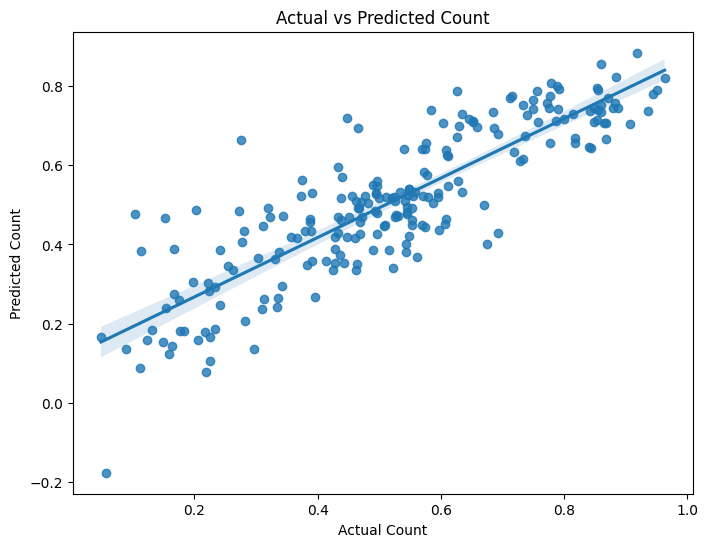

In [51]:
plt.figure(figsize=(8,6))
sns.regplot(x=y_test, y=y_test_pred)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs Predicted Count")
plt.show()

In [ ]:
    #### Calculate RMSE
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    rmse_test, rmse_train

(np.float64(0.1111249207218699), np.float64(0.10537355521020314))

#### Model Evaluation using R2 Score

In [52]:
#### R2 Score for Train Data
r2_train = r2_score(y_train, y_train_pred)
r2_train.__round__(2)

0.78

In [53]:
#### R2 Score for Test Data
r2_test = r2_score(y_test, y_test_pred)
r2_test.__round__(2)

0.74

#### Differnce between R2 train and R2 test is within 5% deviation

In [54]:
R2diffinpercent = (r2_train - r2_test) * 100
R2diffinpercent = R2diffinpercent.__round__(2)
R2diffinpercent

3.74

In [55]:
lm_mdl5.params.round(3).sort_values(ascending=False)

const              0.533
yr_2019            0.248
mnth_Sep           0.071
weekday_Sat        0.065
workingday_Yes     0.056
season_Summer     -0.039
season_Winter     -0.074
weathersit_Mist   -0.087
mnth_Jan          -0.103
windspeed         -0.189
season_Spring     -0.258
weathersit_Rain   -0.302
dtype: float64

#### The Best Fit line equation is :
Equation: Count = 0.533 + 0.248*yr_2019 + 0.056*workingday_Yes + 0.065*weekday_Sat + 0.071*mnth_Sep 
                  +(-0.302*weather_Rain) +( -0.258*season_Spring ) +( - 0.189*windspeed ) +( - 0.103*mnth_Jan )
                  +( - 0.087*weather_mist ) +( - 0.074*season_Winter ) +( - 0.039*season_Summer )